# UMAP of cells of interest

In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
# %load common_.py
from common import *

In [63]:
import umap
import dask.dataframe as dd
from ehv import core, load as e_load
from joblib import dump, load
from pathlib import Path
from matplotlib import cm
import matplotlib
import statsmodels.api as sm

In [64]:
df = e_load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"),
    pandas.read_csv("data/selected_samples.csv"))
df = e_load.remove_unwanted_features(df)
df = e_load.tag_columns(df)
df = e_load.clean_column_names(df)

In [65]:
df = df[df["meta_label_coi"]]
df.shape

(736466, 113)

In [66]:
with open("data/selected_features.txt") as fh:
    features = [i.lower() for i in fh.read().split(",")]
features.extend(df.filter(regex="meta").columns.values.tolist())

df = df[features]

In [67]:
import re
reg = r"^meta_label_(.+)$"
label_vec = numpy.full((df.shape[0]), fill_value="unknown", dtype=object)
for col in df.filter(regex="(?i)meta_label_.*psba.*"):
    label_vec[df[col].values] = re.match(reg, col).groups(1)
    
df["meta_label"] = label_vec

In [68]:
def zscore_feat_cols(col):
    if "feat" in col.name:
        return (col - col.mean(axis=0))/col.std(axis=0)
    else:
        return col

df = df.apply(zscore_feat_cols, axis=0)

In [ ]:
df.groupby(["meta_timepoint", "meta_replicate"]).apply(lambda df: df.apply(zscore_feat_cols, axis=0))

In [48]:
df.shape

(736466, 102)

In [49]:
df = df.loc[df["meta_group"] == "Low"]

## Compute UMAP on all cells of interest

In [26]:
model = umap.UMAP(random_state=42, metric="cosine")

In [27]:
projection = model.fit_transform(df.filter(regex="feat"))

In [28]:
dump(projection, "data/umap/HTR_Low_zscored_selected_samples_and_features")

['data/umap/HTR_Low_zscored_selected_samples_and_features']

In [51]:
df["dim_1"] = projection[:, 0]
df["dim_2"] = projection[:, 1]

<AxesSubplot:xlabel='dim_1', ylabel='dim_2'>

/opt/conda/envs/env/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


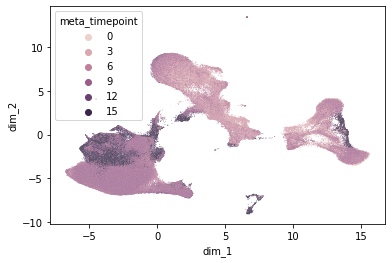

In [35]:
seaborn.scatterplot(data=df, x="dim_1", y="dim_2", hue="meta_timepoint", s=0.5)

<AxesSubplot:xlabel='dim_1', ylabel='dim_2'>

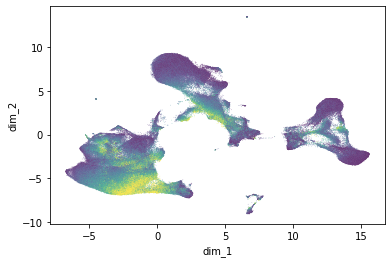

In [58]:
feat = "feat_area_m07"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.05), vmax=df[feat].quantile(0.95))
seaborn.scatterplot(data=df, x="dim_1", y="dim_2", c=df[feat], s=0.5, alpha=0.5, cmap="viridis", norm=norm)

<AxesSubplot:xlabel='dim_1', ylabel='dim_2'>

/opt/conda/envs/env/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


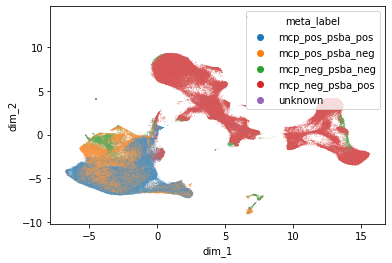

In [59]:
seaborn.scatterplot(data=df, x="dim_1", y="dim_2", hue="meta_label", s=0.5, alpha=0.5)